# 22 : 378

In [1]:
import os, glob, pickle, time
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

import sys
path = os.path.abspath('../../')
print(path)
sys.path.append(path)
from CommonUtil import *

path = os.path.abspath('./models')
print(path)
sys.path.append(path)
import Attention_ResNet_1DCNN as att_res1d

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"]='0'
# os.environ["CUDA_VISIBLE_DEVICES"]='2'
#mirrored_strategy = tf.distribute.MirroredStrategy()

2024-07-18 04:13:21.963883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-18 04:13:22.726687: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.3/lib64:
2024-07-18 04:13:22.727194: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.3/lib64:
2024-07-18 04:13:22.727202: W tensorflow/compiler/tf2tensorrt/utils/py_uti

/home/gil/gcubme_ai2/Workspace/SB_MUN
/home/gil/gcubme_ai2/Workspace/SB_MUN/9_NIA_46_dysarthria/1_source_abstract/models


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
LEARNING_RATE = 1e-4
EPOCHS = 200
BATCH_SIZE = 2
MODEL_NUM = 4
LOSS_FUNCTION = tf.keras.losses.MeanAbsoluteError()
LOSS_FUNCTION = 'binary_crossentropy'
METRICS = tf.keras.metrics.MeanSquaredError()
METRICS = ['accuracy']

TRAIN_SPLIT = 17

2024-07-18 04:13:24.142381: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-18 04:13:24.745664: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78906 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:81:00.0, compute capability: 8.0


In [4]:
length = 64000
model_name = 'AttResNet'  # Modified DenseNet
model_width = 32  # Width of the Initial Layer, subsequent layers start from here
num_channel = 1  # Number of Channels in the Model
problem_type = 'Binary' # Classification or Regression
output_nums = 1  # Number of Class for Classification Problems, always '1' for Regression Problems
# Build, Compile and Print Summary


In [7]:
DATA_PATH = os.path.abspath('./data/preproc2')
RESULT_DIR = os.path.abspath(f'./result')
MODEL_DIR = RESULT_DIR + '/model'

best_model_path = MODEL_DIR + '/best_model.h5'
model_path = MODEL_DIR + '/model.h5'

createFolder(MODEL_DIR)

print(DATA_PATH)
print(MODEL_DIR)

/home/gil/gcubme_ai2/Workspace/SB_MUN/9_NIA_46_dysarthria/1_source_abstract/data/preproc2
/home/gil/gcubme_ai2/Workspace/SB_MUN/9_NIA_46_dysarthria/1_source_abstract/result/model


In [10]:
train_X_csv_list = sorted(glob.glob(f'{DATA_PATH}/train/*.csv'))
validation_X_csv_list = sorted(glob.glob(f'{DATA_PATH}/validation/*.csv'))

print(len(train_X_csv_list))
print(len(validation_X_csv_list))

20000
2500


In [9]:
train_X_npy_list = [csv_path.split('.csv')[0] + '_X.npy' for csv_path in train_X_csv_list]
train_Y_npy_list = [csv_path.split('.csv')[0] + '_Y.npy' for csv_path in train_X_csv_list]
validation_X_npy_list = [csv_path.split('.csv')[0] + '_X.npy' for csv_path in validation_X_csv_list]
validation_Y_npy_list = [csv_path.split('.csv')[0] + '_Y.npy' for csv_path in validation_X_csv_list]


In [11]:
train_X_npy_list, train_Y_npy_list = shuffle(train_X_npy_list, train_Y_npy_list)
validation_X_npy_list, validation_Y_npy_list = shuffle(validation_X_npy_list, validation_Y_npy_list)


In [12]:

def npy_load(X_path_list:list, Y_path_list:list):
    print(f'Total data len : {len(X_path_list)}')
    
    X_data = []
    Y_data = []
    data_paths = []
    
    for a in tqdm_notebook(range(len(X_path_list))):
#     for a in range(5):
        X_path = X_path_list[a]
        Y_path = Y_path_list[a]
    
#         print(f'{a}/{len(X_path_list)}\t==> {X_path}')
        
        X_npy = np.load(X_path)
        Y_npy = np.load(Y_path)
    
        X_data.extend(X_npy)
        Y_data.extend(Y_npy)
        data_paths.append(X_path)
        
    X_data, Y_data = shuffle(X_data, Y_data)
    
    X_data = np.array(X_data)
    Y_data = np.array(Y_data)
    X_data = np.expand_dims(X_data, axis=-1)
    Y_data = np.expand_dims(Y_data, axis=-1)
    print("X_data shape: ", X_data.shape, "\t Y_data shape: ", Y_data.shape)
    
    return X_data, Y_data # ,data_paths

In [13]:
train_X, train_Y = npy_load(train_X_npy_list, train_Y_npy_list)
validation_X, validation_Y = npy_load(validation_X_npy_list, validation_Y_npy_list)


Total data len : 20000


  0%|          | 0/20000 [00:00<?, ?it/s]

X_data shape:  (37407, 64000, 1) 	 Y_data shape:  (37407, 1)
Total data len : 2500


  0%|          | 0/2500 [00:00<?, ?it/s]

X_data shape:  (4801, 64000, 1) 	 Y_data shape:  (4801, 1)


In [14]:

print(list(train_Y).count(0))
print(list(train_Y).count(1))
print('='*50)
print(list(validation_Y).count(0))
print(list(validation_Y).count(1))
print('='*50)

24462
12945
2889
1912


In [15]:
model = att_res1d.AttResNet(length, num_channel, model_width, BATCH_SIZE, 
                      problem_type=problem_type, output_nums=output_nums).AttResNet()
model.compile(optimizer=Adam(LEARNING_RATE), loss=LOSS_FUNCTION, metrics=METRICS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64000, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 64000, 32)    128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64000, 32)   128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 64000, 32)    0           ['batch_normalization[0][0]']

 tf.compat.v1.shape (TFOpLambda  (3,)                0           ['max_pooling1d[0][0]']          
 )                                                                                                
                                                                                                  
 dense (Dense)                  (None, 128, 1000)    1001000     ['tf.compat.v1.transpose[0][0]'] 
                                                                                                  
 tf.__operators__.getitem (Slic  ()                  0           ['tf.compat.v1.shape[0][0]']     
 ingOpLambda)                                                                                     
                                                                                                  
 dense_1 (Dense)                (None, 128, 1000)    1001000     ['tf.compat.v1.transpose[0][0]'] 
                                                                                                  
 tf.reshap

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, History, ReduceLROnPlateau, EarlyStopping

checkpointer = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=1e-8)
earlystopper = EarlyStopping(monitor='val_loss', patience=30, verbose=1)
callbacks_list = [reduce_lr, checkpointer, earlystopper]

# train

In [18]:
from datetime import datetime
startTime = datetime.now()

print('Start Time : {0}'.format(startTime))
###############################################################################################

hist = model.fit(train_X, train_Y, 
                 batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, 
                 validation_data = (validation_X, validation_Y), 
                 callbacks=callbacks_list)

################################################################################################

endTime = datetime.now()
runTime = endTime - startTime

print('End Time : {0}'.format(endTime))
print('Running Time : ' + str(runTime))

print('Done training')

Start Time : 2024-01-10 14:43:25.830545
Epoch 1/200


2024-01-10 14:43:39.783477: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2024-01-10 14:43:43.483659: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1169/1169 [==============================] - ETA: 0s - loss: 0.1467 - accuracy: 0.9451
Epoch 1: val_loss improved from inf to 2.50938, saving model to /home/gil/gcubme_ai3/Workspace/SB_MUN/9_NIA_46_dysarthria/1_source_abstract/result/model/best_model.h5
1169/1169 [==============================] - 624s 522ms/step - loss: 0.1467 - accuracy: 0.9451 - val_loss: 2.5094 - val_accuracy: 0.4076 - lr: 1.0000e-04
Epoch 2/200
1169/1169 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 0.9696
Epoch 2: val_loss improved from 2.50938 to 1.65532, saving model to /home/gil/gcubme_ai3/Workspace/SB_MUN/9_NIA_46_dysarthria/1_source_abstract/result/model/best_model.h5
1169/1169 [==============================] - 603s 516ms/step - loss: 0.0868 - accuracy: 0.9696 - val_loss: 1.6553 - val_accuracy: 0.4012 - lr: 1.0000e-04
Epoch 3/200
1169/1169 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.9788
Epoch 3: val_loss improved from 1.65532 to 0.82521, saving model to /

Epoch 25/200
1169/1169 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9997
Epoch 25: val_loss did not improve from 0.13011
1169/1169 [==============================] - 593s 507ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.1593 - val_accuracy: 0.9638 - lr: 1.0000e-06
Epoch 26/200
1169/1169 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9997
Epoch 26: val_loss did not improve from 0.13011
1169/1169 [==============================] - 592s 507ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.1474 - val_accuracy: 0.9677 - lr: 1.0000e-06
Epoch 27/200
1169/1169 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.9997
Epoch 27: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 27: val_loss did not improve from 0.13011
1169/1169 [==============================] - 592s 506ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.1488 - val_accuracy: 0.9696 - lr: 1.0000e-06
Epoch 28/200
116

In [19]:
model.save(model_path)

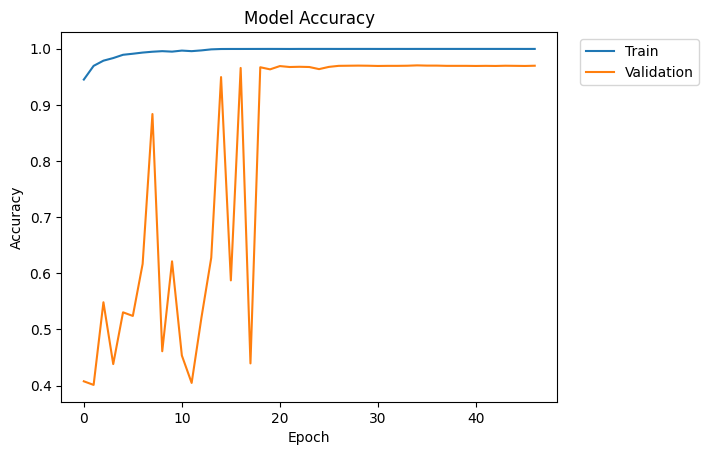

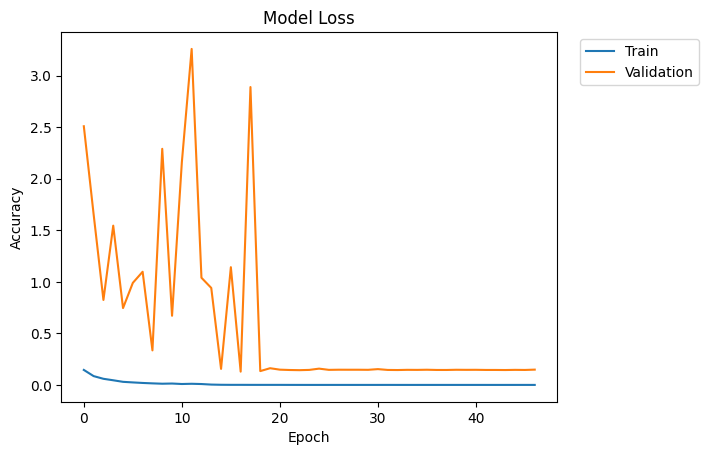

In [20]:
import matplotlib.pylab as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
# plt.plot(hist.history['val_loss'])
# plt.plot(hist.history['loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
# plt.plot(hist.history['val_loss'])
# plt.plot(hist.history['loss'])
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

# test

In [21]:
test_X_csv_list = sorted(glob.glob(f'{DATA_PATH}/test/*.csv'))
print(len(test_X_csv_list))

test_X_npy_list = [csv_path.split('.csv')[0] + '_X.npy' for csv_path in test_X_csv_list]
test_Y_npy_list = [csv_path.split('.csv')[0] + '_Y.npy' for csv_path in test_X_csv_list]

test_X, test_Y = npy_load(test_X_npy_list, test_Y_npy_list)

2500
Total data len : 2500


  0%|          | 0/2500 [00:00<?, ?it/s]

X_data shape:  (4757, 64000, 1) 	 Y_data shape:  (4757, 1)


In [22]:
from keras.models import load_model

model = load_model(best_model_path)

In [23]:
predicted = model.predict(test_X, batch_size=64, verbose=1)

75/75 [==============================] - 23s 245ms/step


In [24]:
predict_Y = predicted > 0.5

In [25]:
print(list(predict_Y).count(0))
print(list(predict_Y).count(1))
print('='*50)
print(list(test_Y).count(0))
print(list(test_Y).count(1))


2997
1760
3087
1670


In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.metrics import sensitivity_score, specificity_score

cm = confusion_matrix(test_Y, predict_Y)
sensitivity = sensitivity_score(test_Y, predict_Y)
specificity = specificity_score(test_Y, predict_Y)
accuracy = accuracy_score(test_Y, predict_Y)
precision = precision_score(test_Y, predict_Y)
f1 = f1_score(test_Y, predict_Y)

print(cm)
print(f'sensitivity : {round(sensitivity*100, 2)}')
print(f'specificity : {round(specificity*100, 2)}')
print(f'accuracy    : {round(accuracy*100, 2)}')
print(f'precision   : {round(precision*100, 2)}')
print(f'f1          : {round(f1*100, 2)}')


[[2938  149]
 [  59 1611]]
sensitivity : 96.47
specificity : 95.17
accuracy    : 95.63
precision   : 91.53
f1          : 93.94


In [ ]:
# Attention resnet